In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np

In [2]:
# train and test are splitted by time
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

### Описание данных

In [3]:
train_df.head()

,city_56_cat_distribution_ekb,city_56_cat_distribution_kazan,city_56_cat_distribution_kransnodar,city_56_cat_distribution_moscow,city_56_cat_distribution_others,city_56_cat_distribution_spb,discount_value_56_sum,duration_sec_56_sum_with_orders,duration_sec_56_sum_wo_orders,is_control,...,session_part_of_local_day_56_cat_distribution_21-24,session_part_of_local_day_56_cat_distribution_3-6,session_part_of_local_day_56_cat_distribution_6-9,session_part_of_local_day_56_cat_distribution_9-12,session_with_offer_56_conversion_rate,success_orders_56_cnt,travel_distance_km_56_sum,travel_time_min_56_sum,exp_discount_value,exp_n_trips
0,0.0,0.0,0.0,0.866667,0.133333,0.0,112.0,10141,9369,True,...,0.202381,0.000000,0.035714,0.095238,0.400000,30,214.623,479.35,0.000000,5.526326
1,0.0,0.0,0.0,0.000000,1.000000,0.0,57.0,938,19152,False,...,0.326923,0.019231,0.057692,0.000000,0.347826,16,156.276,265.90,10.252258,1.230271
2,0.0,0.0,0.0,0.944444,0.055556,0.0,12.0,7176,6947,False,...,0.126437,0.011494,0.034483,0.229885,0.507042,36,195.984,377.00,0.000000,1.000503
3,0.0,0.0,0.0,0.939394,0.060606,0.0,86.0,7054,6011,False,...,0.103896,0.012987,0.025974,0.207792,0.540984,33,174.685,345.10,0.000000,0.410090
4,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0,0,False,...,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000,0.00,0.000000,0.000000


Фичи, которые относятся к эксперименту и **не должны** быть использованы как признаки модели:   
exp_discount_value - сумма скидок, которую получил пользователь во время экперимента   
exp_n_trips - число поездок, которые совершил пользовать во время экперимента  

is_control - был ли человек в контрольной группе во время эксперимента (в некоторых случаях можно использовать как признак) 

Дальше идут фичи, которые **можно** использовать как признаки модели.  
Все фичи пользователей посчитаны за последние 56 дней перед проведением теста.

**Категориальные фичи**, которые переведены в пропорции от 0 до 1 по категориям:    
city_56_cat_distribution_* - город cовершения заказа  
session_local_weekday_56_cat_distribution_* - сессия: день недели    
session_local_weekend_56_cat_distribution_* - сессия: рабочий / выходной день  
session_part_of_local_day_56_cat_distribution_* - сессия: часть дня в разбивке по 3 часа  
order_local_weekday_56_cat_distribution_* - заказ: день недели    
order_local_weekend_56_cat_distribution_* - заказ: рабочий / выходной день  
order_part_of_local_day_56_cat_distribution_* - заказ: часть дня в разбивке по 3 часа  


**Числовые фичи:**  
discount_value_56_sum - сумма скидок  
duration_sec_56_sum_with_orders - сумма длительности сессий пользователя, когда он в итоге сделал заказ  
duration_sec_56_sum_wo_orders - сумма длительности сессий пользователя, когда он заказ не сделал
last_absent_days - сколько дней пользователь не совершал заказов  
last_absent_days_wo_sessions - сколько дней пользователь не заходил в приложение  
missed_days_orders_56_mean - интервал между заказами в днях  
missed_days_sessions_56_mean - интервал между сессиями в днях
offer_cnt_56_conversion_rate - конверсия из оффера в заказ  
offer_cnt_56_sum_with_orders - сумма офферов с заказами  
offer_cnt_56_sum_wo_orders - сумма офферов без заказа  
order_cost_rur_56_sum - сумма стоимости всех заказов  
session_with_offer_56_conversion_rate - конверсия из сессии в заказ  
success_orders_56_cnt - число всех заказов  
travel_distance_km_56_sum - расстояние по всем заказам  
travel_time_min_56_sum - длительность по всем заказам  

### Пример

В качестве модели в Uplift моделировании может быть любая функция, которая позволяет ранжировать пользователей.  
Я решил использовать одну из фичей: количество поездок за 56 дней в качестве скора.

In [4]:
train_preds = -train_df.success_orders_56_cnt.values
test_preds = -test_df.success_orders_56_cnt.values

In [5]:
train_metric_df = pd.DataFrame({
    'Model': train_preds,
    'w': ~train_df.is_control.values,
    'y': train_df.exp_n_trips
})

test_metric_df = pd.DataFrame({
    'Model': test_preds,
    'w': ~test_df.is_control.values,
    'y': test_df.exp_n_trips
})

### Валидация

Теперь посмотрим на то, что у нас получилось.  
Основная метрика, которая интересует бизнес - это стомость доп трипа (COT):
$$COT = {\overline{discount_{test}} - \overline{disount_{control}} \over \overline{trips_{test}} - \overline{trips_{control}}} $$
Я немного переделал код из casualml, чтобы можно было посчитать эту метрику.  
Идея такая же - можем посмотреть на график и отдельно на AUUC.

In [6]:
from utils import CostMetrics

In [7]:
cost = CostMetrics(pd.DataFrame({
    'Model': test_preds,
    'w': ~test_df.is_control.values,
    'exp_n_trips': test_df.exp_n_trips,
    'exp_discount_value': test_df.exp_discount_value
}))

In [8]:
cost.get_cumlift()

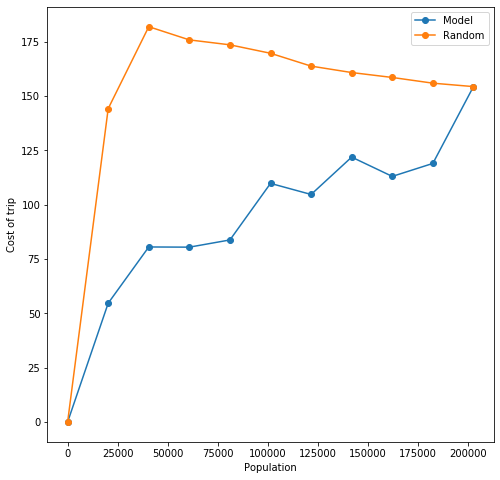

In [9]:
cost.plot()

In [10]:
cost.auuc_score()

Model      98.662298
Random    174.159396
dtype: float64

### Задание 1

Используйте метод трансформации таргета, чтобы показать результат не хуже, чем у такого простого решения, как ранжирование по одной фиче.  
В качестве таргета используйте exp_n_trips.  
Не забывайте про необходимость посмотреть на данные, почистить их и так далее.

### Задание 2

Предложите свой способ разбиения пользователей на 4 группы по uplift-скору.  
То есть нужно перейти от индивидуальных значений по скору к групповым.  
Обоснуйте свой выбор с помощью метрик и/или графиков.  

### Задание 3 - творческое

Попробуйте придумать свой подход к оптимизации стоимости доп трипа.  
Скорее всего, это потребует выйти за рамки реализованных библиотек.  
Как возможные идеи: 
* подумать о новом критерии для сплита дерева, 
* изменить таргет для пользователя, 
* оптимизировать таргет на группе